## Map refresh - Baseline 

In [3]:
import configparser
from pathlib import Path
import pandas as pd
import pandas.io.sql as pandasql
from psycopg2 import connect
import numpy
from psycopg2.extras import execute_values
from datetime import datetime
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import copy
import rick
import geopandas as gpd
import seaborn as sns
import shapely
import matplotlib.patches as patches
import matplotlib.ticker as ticker
from setuptools import setup, find_packages
from math import factorial
from simanneal import Annealer
from itertools import islice 
import matplotlib.patches as patches
CONFIG = configparser.ConfigParser()
CONFIG.read(str(Path.home().joinpath('db.cfg')))
from itertools import combinations, chain
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

In [12]:
def make_map(data, basemap_b, centreline_b, highway_b, color, title):
    f, ax = plt.subplots(figsize=(20,20))
    if basemap_b == True:
        basemap.plot(ax=ax, color = 'grey', alpha=0.2)
    if centreline_b == True:
        centreline.plot(ax=ax, color = 'white', alpha=0.2)
    if highway_b == True:
        highway.plot(ax=ax, color = 'white', alpha=0.2)    
    
    data.plot(column = 'id', ax=ax, cmap=color)
    NUM_COLORS = len(data.col.unique())
    cm = plt.get_cmap(color)
    colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
    handles, labels = [], []

    legend_id = data.col.unique()
    for i in range(0, NUM_COLORS):
        label_name = legend_id[i]
        handles.append(mpl.patches.Patch(color=colors[i],label=label_name))
    ax.legend(handles=handles,loc='lower right', ncol=1, title = title)    
    ax.set_axis_off()

## Distribution of baseline speed using different speed pecentiles

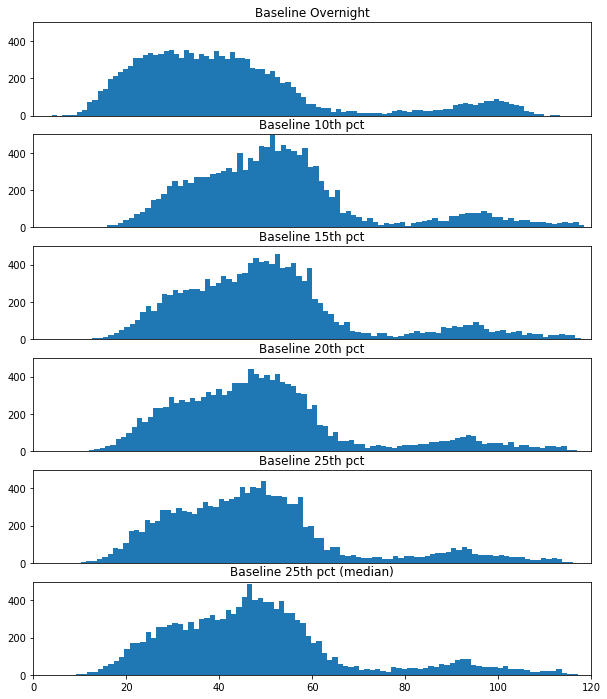

In [2]:
speed_dis1 = pd.read_sql('''select * from congestion.tt_segments_baseline_v5_2019_af''',con)

fig, ax = plt.subplots(6, 1, figsize=(10,12))
ax[0].hist(speed_dis1.spd_baseline_overnight_corr, 100)
ax[0].set_title('Baseline Overnight')
ax[0].get_xaxis().set_visible(False)
ax[0].set_ylim(0, 500)
ax[0].set_xlim(0, 120)
ax[1].hist(speed_dis1.spd_baseline_10pct_corr, 100)
ax[1].set_title('Baseline 10th pct')
ax[1].set_ylim(0, 500)
ax[1].set_xlim(0, 120)
ax[1].get_xaxis().set_visible(False)
ax[2].hist(speed_dis1.spd_baseline_15pct_corr, 100)
ax[2].set_title('Baseline 15th pct')
ax[2].get_xaxis().set_visible(False)
ax[2].set_ylim(0, 500)
ax[2].set_xlim(0, 120)
ax[3].hist(speed_dis1.spd_baseline_20pct_corr, 100)
ax[3].set_title('Baseline 20th pct')
ax[3].set_ylim(0, 500)
ax[3].set_xlim(0, 120)
ax[3].get_xaxis().set_visible(False)
ax[4].hist(speed_dis1.spd_baseline_25pct_corr, 100)
ax[4].set_title('Baseline 25th pct')
ax[4].set_ylim(0, 500)
ax[4].set_xlim(0, 120)
ax[4].get_xaxis().set_visible(False)
ax[5].hist(speed_dis1.spd_baseline_25pct_med_corr, 100)
ax[5].set_title('Baseline 25th pct (median)')
ax[5].set_ylim(0, 500)
ax[5].set_xlim(0, 120)

fig.show()

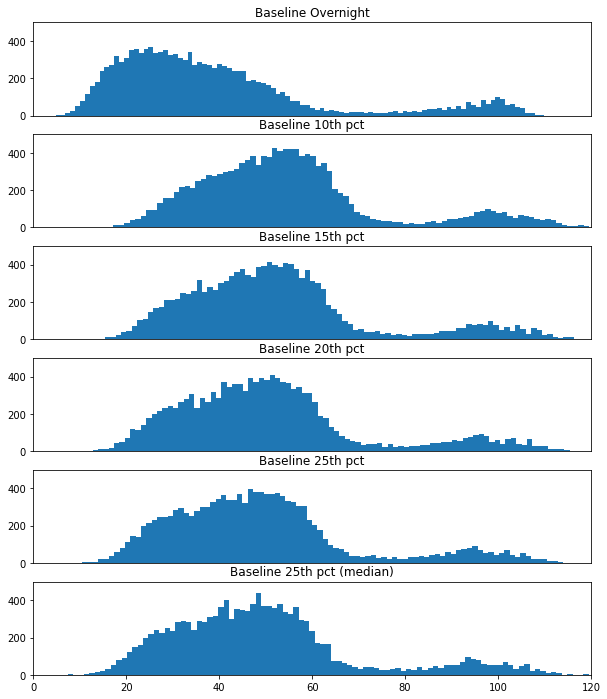

In [4]:
speed_dis1 = pd.read_sql('''select * from congestion.tt_segments_baseline_v6_2019''',con)

fig, ax = plt.subplots(6, 1, figsize=(10,12))
ax[0].hist(speed_dis1.spd_baseline_overnight, 100)
ax[0].set_title('Baseline Overnight')
ax[0].get_xaxis().set_visible(False)
ax[0].set_ylim(0, 500)
ax[0].set_xlim(0, 120)
ax[1].hist(speed_dis1.spd_baseline_10pct, 100)
ax[1].set_title('Baseline 10th pct')
ax[1].set_ylim(0, 500)
ax[1].set_xlim(0, 120)
ax[1].get_xaxis().set_visible(False)
ax[2].hist(speed_dis1.spd_baseline_15pct, 100)
ax[2].set_title('Baseline 15th pct')
ax[2].get_xaxis().set_visible(False)
ax[2].set_ylim(0, 500)
ax[2].set_xlim(0, 120)
ax[3].hist(speed_dis1.spd_baseline_20pct, 100)
ax[3].set_title('Baseline 20th pct')
ax[3].set_ylim(0, 500)
ax[3].set_xlim(0, 120)
ax[3].get_xaxis().set_visible(False)
ax[4].hist(speed_dis1.spd_baseline_25pct, 100)
ax[4].set_title('Baseline 25th pct')
ax[4].set_ylim(0, 500)
ax[4].set_xlim(0, 120)
ax[4].get_xaxis().set_visible(False)
ax[5].hist(speed_dis1.spd_baseline_25pct_med, 100)
ax[5].set_title('Baseline 25th pct (median)')
ax[5].set_ylim(0, 500)
ax[5].set_xlim(0, 120)

fig.show()

In [6]:
# basemap and centreline highway sql for mapping
basemap_query = '''select gis.geopandas_transform(ST_union(geom)) as geom from gis.neighbourhood'''
basemap = gpd.GeoDataFrame.from_postgis(basemap_query, con, geom_col='geom')
basemap = basemap.to_crs({'init' :'epsg:26917'})

centreline_query = '''select gis.geopandas_transform(ST_linemerge(geom)) as geom 
                    from gis.centreline where fcode_desc in ('Expressway','Expressway Ramp')
                    '''
highway = gpd.GeoDataFrame.from_postgis(centreline_query, con, geom_col='geom')
highway = highway.to_crs({'init' :'epsg:26917'})

centreline_all_query = '''select gis.geopandas_transform(ST_linemerge(geom)) as geom 
                    from gis.centreline where fcode_desc in ('Collector','Collector Ramp','Expressway','Expressway Ramp',
                    'Local','Major Arterial','Major Arterial Ramp','Minor Arterial',
                    'Minor Arterial Ramp','Pending')
                    '''
centreline = gpd.GeoDataFrame.from_postgis(centreline_all_query, con, geom_col='geom')
centreline = centreline.to_crs({'init' :'epsg:26917'})

/etc/jupyterhub/.venv/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [15]:
baseline_speed = '''with color as (
		select row_number() over() as id, val::text ||' - '|| (lag(val,-1 ) over (order by val))::text as col, val, lag(val,-1 ) over (order by val) as next_val 
		from (
		SELECT generate_series(10.0,125.0, '5') as val )a )																				 
, temp as (																				 
select segment_id, CASE	WHEN highway.segment_id IS NOT NULL 
							THEN spd_baseline_10pct_corr 
						ELSE
							spd_baseline_25pct_corr 
				END AS baseline_speed,
	(ST_dump(st_linemerge(geom))).geom as geom
from congestion.tt_segments_baseline_v5_2019_af																									   
inner join congestion.segments_v5 using (segment_id)
LEFT JOIN 	congestion.highway_segments_v5 highway USING (segment_id)

)
select id, col, segment_id, baseline_speed,  gis.geopandas_transform(st_offsetcurve(geom, -0.0006)) as geom
from temp
inner join color on baseline_speed between val and next_val 
where ST_astext(st_offsetcurve(((st_linemerge(geom))), -0.0006)) != 'LINESTRING EMPTY' and ST_geometrytype(geom) = 'ST_LineString' and col is not null
order by id
                '''
baseline_speed_segments = gpd.GeoDataFrame.from_postgis(baseline_speed, con, geom_col='geom')
baseline_speed_segments = baseline_speed_segments.to_crs({'init' :'epsg:26917'})

/etc/jupyterhub/.venv/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [16]:
baseline_speed_new = '''with color as (
		select row_number() over() as id, val::text ||' - '|| (lag(val,-1 ) over (order by val))::text as col, val, lag(val,-1 ) over (order by val) as next_val 
		from (
		SELECT generate_series(10.0,125.0, '5') as val )a )																				 
, temp as (																				 
select segment_id, CASE	WHEN highway.segment_id IS NOT NULL 
							THEN spd_baseline_10pct 
						ELSE
							spd_baseline_25pct 
				END AS baseline_speed,
	(ST_dump(st_linemerge(geom))).geom as geom
from congestion.tt_segments_baseline_v6_2019  
inner join congestion.segments_v6 using (segment_id)
LEFT JOIN 	congestion.highway_segments_v6 highway USING (segment_id)

)
select id, col, segment_id, baseline_speed,  gis.geopandas_transform(st_offsetcurve(geom, -0.0006)) as geom
from temp
inner join color on baseline_speed between val and next_val 
where ST_astext(st_offsetcurve(((st_linemerge(geom))), -0.0006)) != 'LINESTRING EMPTY' and ST_geometrytype(geom) = 'ST_LineString' and col is not null
order by id
                '''
baseline_speed_segments_new = gpd.GeoDataFrame.from_postgis(baseline_speed_new, con, geom_col='geom')
baseline_speed_segments_new = baseline_speed_segments_new.to_crs({'init' :'epsg:26917'})

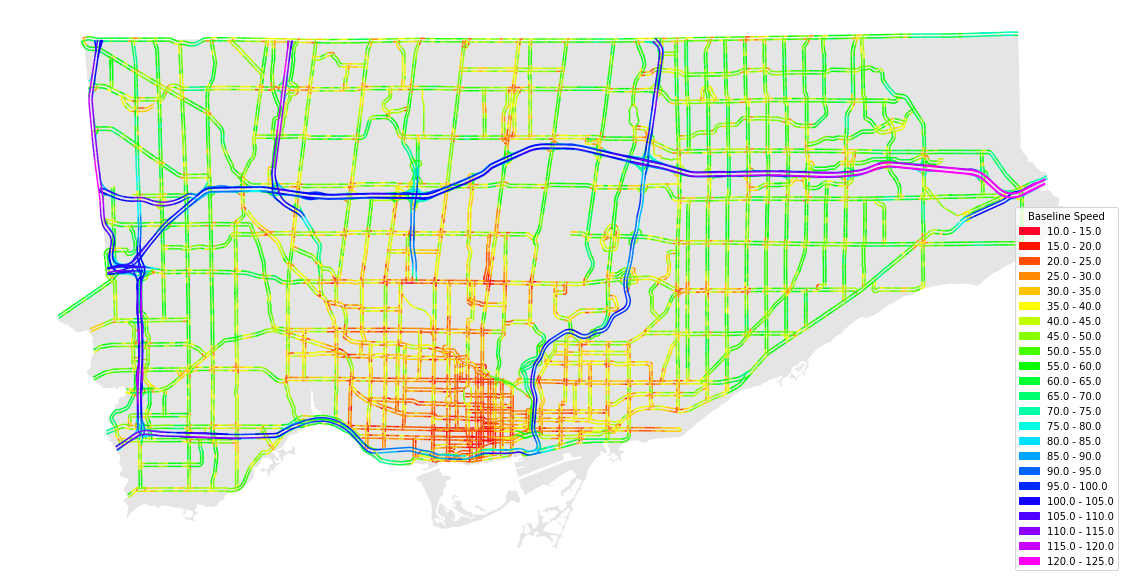

In [17]:
make_map(baseline_speed_segments, True, False, False, 'gist_rainbow', 'Baseline Speed')

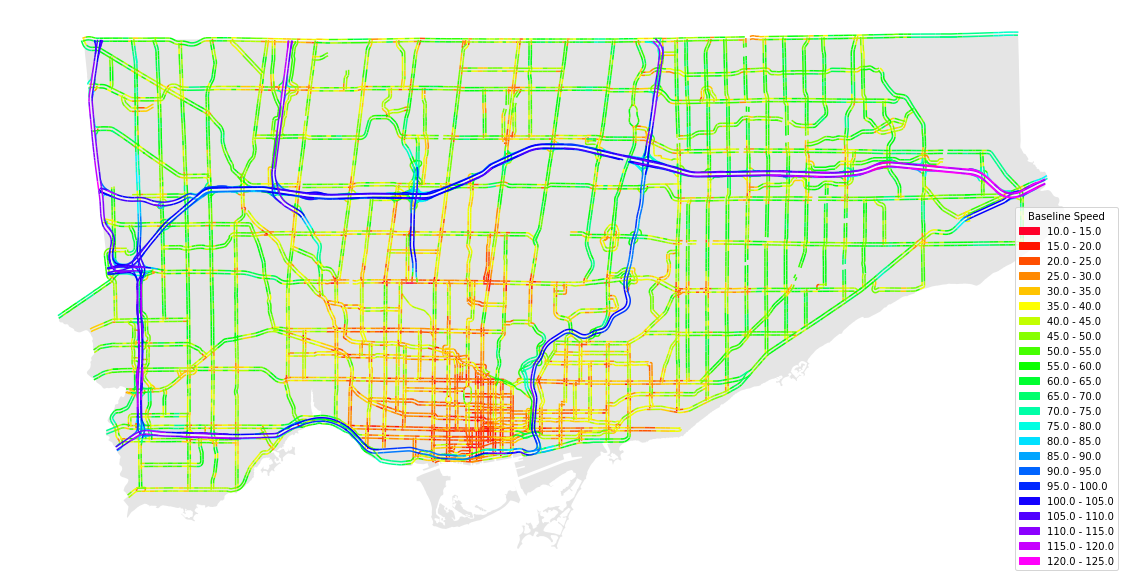

In [20]:
make_map(baseline_speed_segments_new, True, False, True, 'gist_rainbow', 'Baseline Speed')

In [5]:
def is_day_one(date_to_pull):
    execution_date = datetime.strptime(date_to_pull, "%Y-%m-%d")	
    if execution_date.day == 1:		
        return	True
    else: 
        return False

In [6]:
is_day_one('2020-06-01')

True